<a href="https://colab.research.google.com/github/otanet/NLP_seminar_20201022/blob/main/%5B%E7%99%BA%E5%B1%95%5D_AllenNLP%E3%81%AB%E3%82%88%E3%82%8B%E8%87%AA%E7%84%B6%E8%A8%80%E8%AA%9E%E5%87%A6%E7%90%86_(3)_BERT%E3%81%AB%E3%82%88%E3%82%8B%E5%9B%BA%E6%9C%89%E8%A1%A8%E7%8F%BE%E8%AA%8D%E8%AD%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AllenNLPによる自然言語処理 (3): BERTによる固有表現認識

**他のノートブックへのリンク：**

* [AllenNLPによる自然言語処理 (1): bag-of-embeddingsモデルによる文書分類](https://colab.research.google.com/drive/1yquPsCgv7EpNPheqt_Th-j-kK3CN2VWQ?usp=sharing)
* [AllenNLPによる自然言語処理 (2): 畳み込みニューラルネットワークによる感情分析](https://colab.research.google.com/drive/1v0YHDTFbQYixdxWf-pp1pZRZ4nkcsy2b?usp=sharing)

このノートブックでは、ディープラーニングを用いた自然言語処理のためのツールであるAllenNLPを用いて、[BERT](https://arxiv.org/abs/1810.04805)を用いた**固有表現認識**のシステムを作成します。

固有表現認識は、テキストから固有表現（固有名詞や日付、時間表現など）を抽出し、クラス（人名、地名、組織名など）に分類するタスクです。

テキスト中の単語の系列に対して、固有表現のラベルを**BIO**（**Begin**, **Inside**, **Outside**）形式で付与したものを下記の図に示します。
BIO形式では「B」が固有表現の開始位置であること、「I」が固有表現に含まれること、「O」が固有表現に含まれないことをあらわします。
またBとIを用いる際は、該当する型名を連結して「B-型名」、「I-型名」（例：B-LOC、I-ORG）のような形式を用います。


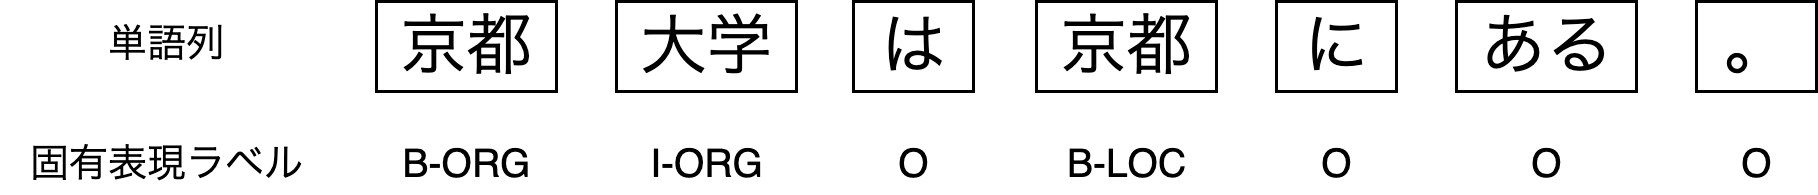

## 環境のセットアップ

本ノートブックの実行に必要なパッケージをインストールします。

In [ ]:
# MeCabをインストール
!apt-get -qq install mecab swig libmecab-dev mecab-ipadic-utf8
# 必要なPythonライブラリをインストール
# （boto3はAllenNLPの依存ライブラリだが、最新バージョンだとエラーになるためバージョンを指定）
!pip install "mecab-python3==0.996.5" "allennlp==1.1.0" "allennlp-models==1.1.0" "pyknp==0.4.1" "boto3==1.15.0"

Selecting previously unselected package libmecab2:amd64.
(Reading database ... 144611 files and directories currently installed.)
Preparing to unpack .../0-libmecab2_0.996-5_amd64.deb ...
Unpacking libmecab2:amd64 (0.996-5) ...
Selecting previously unselected package libmecab-dev.
Preparing to unpack .../1-libmecab-dev_0.996-5_amd64.deb ...
Unpacking libmecab-dev (0.996-5) ...
Selecting previously unselected package mecab-utils.
Preparing to unpack .../2-mecab-utils_0.996-5_amd64.deb ...
Unpacking mecab-utils (0.996-5) ...
Selecting previously unselected package mecab-jumandic-utf8.
Preparing to unpack .../3-mecab-jumandic-utf8_7.0-20130310-4_all.deb ...
Unpacking mecab-jumandic-utf8 (7.0-20130310-4) ...
Selecting previously unselected package mecab-jumandic.
Preparing to unpack .../4-mecab-jumandic_7.0-20130310-4_all.deb ...
Unpacking mecab-jumandic (7.0-20130310-4) ...
Selecting previously unselected package mecab-ipadic.
Preparing to unpack .../5-mecab-ipadic_2.7.0-20070801+main-1_a

## データセットのセットアップ

本ノートブックでは、[京都大学ウェブ文書リードコーパス](http://nlp.ist.i.kyoto-u.ac.jp/index.php?KWDLC)を用います。

このデータセットでは、ウェブから取得した5,000件の文書の冒頭の3文に対して品詞や固有表現ラベル等のアノテーションが付与されています。
ウェブから取得した文書にはニュース記事、百科事典記事、ブログ、商用ページなどのさまざまな種類が含まれています。
本ノートブックでは、このデータセットの固有表現ラベルを用いてモデルの構築を行います。

### データセットのダウンロード

データセットをGitHubからクローンして、`data/kwdlc/repo`に格納します。

In [ ]:
!mkdir -p data/kwdlc
!git clone https://github.com/ku-nlp/KWDLC.git data/kwdlc/repo

Cloning into 'data/kwdlc/repo'...
remote: Enumerating objects: 22505, done.
remote: Counting objects: 100% (22505/22505), done.
remote: Compressing objects: 100% (6720/6720), done.
remote: Total 22505 (delta 15828), reused 22454 (delta 15781), pack-reused 0
Receiving objects: 100% (22505/22505), 15.58 MiB | 8.14 MiB/s, done.
Resolving deltas: 100% (15828/15828), done.


### データセットをCoNLL-2003形式に変換

データセットを 固有表現認識のデータセットの標準的な形式である[CoNLL-2003形式](https://www.clips.uantwerpen.be/conll2003/ner/)に変換します。
このスクリプトはデータセットを読み込んで8:1:1の割合でそれぞれ訓練用、検証用、テスト用に分割し、保存します。

In [ ]:
import glob
import os
import random
import re
from pyknp import BList

def add_ne_tag_to_mrphs(result):
    """基本句(「+」から始まる行)に付与されている固有表現タグを各形態素に付与"""
    for tag in result.tag_list():
        # 例: <NE:LOCATION:千里中央駅>
        match = re.search(r"<NE:(.+?):(.+?)>", tag.fstring)
        if not match:
            continue

        ne_type, ne_target = match.groups()
        
        # 曖昧性が高いなどの理由によりタグ付けが困難なものにはOPTIONALタグが付与されており、
        # このタグは対象としない。
        # (IREXの評価では、OPTIONALが付与されているものに対してシステムが何らかのタグを推定した場合、
        # それを誤りとみなさない処置が行われているが、ここでは簡易的なものとしてそのような評価は行わず、
        # 単にOPTIONALタグを無視したデータ作成とする。
        # IREXの評価の詳細は https://nlp.cs.nyu.edu/irex/NE/df990214.txt の「1.1 オプショナル」節を参照のこと)
        if ne_type == "OPTIONAL":
            continue

        # 固有表現の末尾の形態素が含まれる基本句に固有表現タグが付与されているので
        # その基本句内で固有表現末尾の形態素を探す
        for mrph in reversed(tag.mrph_list()):
            if not ne_target.endswith(mrph.midasi):
                continue

            # 固有表現を構成する形態素id列を得る
            ne_mrph_ids = get_ne_mrph_ids(mrph.mrph_id, ne_target, result)
            # 各形態素にNEタグを付与
            for i, ne_mrph_id in enumerate(ne_mrph_ids):
                target_mrph = result.mrph_list()[ne_mrph_id]
                # 固有表現の先頭はラベルB、それ以外はラベルI
                target_mrph.fstring += "<NE:{}:{}/>".format(
                    ne_type, "B" if i == 0 else "I")

def get_ne_mrph_ids(last_mrph_id, ne_target, result):
    """固有表現を構成する形態素id列を得る"""
    ne_mrph_ids = []
    string = ""
    for i in range(last_mrph_id, -1, -1):
        ne_mrph_ids.insert(0, i)
        string = result.mrph_list()[i].midasi + string

        # 固有表現先頭まで来たので形態素id列を返す
        if string == ne_target:
            return ne_mrph_ids

def write_file(out_file, docs):
    """データセットをファイルに書き出す"""
    with open(out_file, "w") as f:
        for doc in docs:
            for result in doc:
                for mrph in result.mrph_list():
                    match = re.search(r"<NE:(.+?):([BI])/>", mrph.fstring)
                    if match:
                        # B-PERSONのような形式の固有表現ラベルを作成
                        ne_tag = "{}-{}".format(match.group(2), match.group(1))
                    else:
                        # 固有表現ラベルの無い場合は"O"ラベルを付与
                        ne_tag = "O"
                    # 1カラム目に単語、4カラム目に固有表現ラベルを書く
                    # それ以外のカラムは利用しない
                    f.write("{} N/A N/A {}\n".format(mrph.midasi, ne_tag))
                f.write("\n")

docs = []
# データセットに含まれる各文書ファイルを順に読み込む
for doc_file in sorted(glob.glob("data/kwdlc/repo/knp/*/*", recursive=True)):
    results = []
    with open(doc_file) as f:
        # 文書に含まれる文とその固有表現ラベルを読み込む
        buf = ""
        for line in f:
            buf += line
            if "EOS" in line:
                result = BList(buf)
                add_ne_tag_to_mrphs(result)
                results.append(result)
                buf = ""
    docs.append(results)

# データセットをランダムに並べ替える
random.seed(1234)
random.shuffle(docs)

# データセットの80%を訓練データ、10%を検証データ、10%をテストデータとして用いる
num_train = int(0.8 * len(docs))
num_test = int(0.1 * len(docs))
train_docs = docs[:num_train]
validation_docs = docs[num_train:-num_test]
test_docs = docs[-num_test:]

# データセットをファイルに書き込む
write_file("data/kwdlc/kwdlc_ner_train.txt", train_docs)
write_file("data/kwdlc/kwdlc_ner_validation.txt", validation_docs)
write_file("data/kwdlc/kwdlc_ner_test.txt", test_docs)

実行が終わると下記の3個のファイルが`data/kwdlc`に生成されます。

* **訓練用のデータ**: `kwdlc_ner_train.txt`
* **検証用のデータ**: `kwdlc_ner_validation.txt`
* **テスト用のデータ**: `kwdlc_ner_test.txt`

In [ ]:
!ls data/kwdlc/*.txt

data/kwdlc/kwdlc_ner_test.txt	data/kwdlc/kwdlc_ner_validation.txt
data/kwdlc/kwdlc_ner_train.txt


データセットが正しく作成されているか確認します。

各行に値が空白区切りで格納されていて、最初の値が単語、最後の値が固有表現のラベルに対応します。2カラム目、3カラム目は使用しないので「N/A」になっています。

In [ ]:
!head -n100 data/kwdlc/kwdlc_ner_train.txt

自然 N/A N/A O
豊かな N/A N/A O
この N/A N/A O
場所 N/A N/A O
で N/A N/A O
、 N/A N/A O
愛する N/A N/A O
ペット N/A N/A O
に N/A N/A O
最大の N/A N/A O
愛 N/A N/A O
を N/A N/A O
贈る N/A N/A O
。 N/A N/A O

それ N/A N/A O
は N/A N/A O
家族 N/A N/A O
と N/A N/A O
して N/A N/A O
過ごして N/A N/A O
くれた N/A N/A O
ペット N/A N/A O
へ N/A N/A O
の N/A N/A O
感謝 N/A N/A O
の N/A N/A O
気持ち N/A N/A O
です N/A N/A O
。 N/A N/A O

その N/A N/A O
気持ち N/A N/A O
に N/A N/A O
応える N/A N/A O
ため N/A N/A O
私 N/A N/A O
達 N/A N/A O
は N/A N/A O
真心 N/A N/A O
を N/A N/A O
こめて N/A N/A O
手厚い N/A N/A O
供養 N/A N/A O
を N/A N/A O
続け N/A N/A O
ます N/A N/A O
。 N/A N/A O

お N/A N/A O
久しぶりです N/A N/A O
。 N/A N/A O

我が家 N/A N/A O
の N/A N/A O
のあ N/A N/A O
君 N/A N/A O
も N/A N/A O
２ N/A N/A O
才 N/A N/A O
に N/A N/A O
なり N/A N/A O
ました N/A N/A O
。 N/A N/A O

パピー N/A N/A O
時代 N/A N/A O
より N/A N/A O
ずいぶん N/A N/A O
と N/A N/A O
成長 N/A N/A O
し N/A N/A O
、 N/A N/A O
問題 N/A N/A O
行動 N/A N/A O
が N/A N/A O
少なく N/A N/A O
なり N/A N/A O
のびのび N/A N/A O
と N/A N/A O
育って N/A N/A O
い N/A N/A O
ます

## 設定ファイルの作成

下記にBERTを用いた固有表現抽出のモデルの設定ファイルを示します。


In [ ]:
model_config = """
{
    "dataset_reader": {
        "type": "conll2003",
        "tag_label": "ner",
        "token_indexers": {
            "transformer": {
                "type": "pretrained_transformer_mismatched",
                "model_name": "cl-tohoku/bert-base-japanese-whole-word-masking"
            }
        }
    },
    "train_data_path": "data/kwdlc/kwdlc_ner_train.txt",
    "validation_data_path": "data/kwdlc/kwdlc_ner_validation.txt",
    "model": {
        "type": "crf_tagger",
        "label_encoding": "BIO",
        "calculate_span_f1": true,
        "text_field_embedder": {
            "token_embedders": {
                "transformer": {
                    "type": "pretrained_transformer_mismatched",
                    "model_name": "cl-tohoku/bert-base-japanese-whole-word-masking"
                }
            }
        },
        "encoder": {
           "type": "pass_through",
           "input_dim": 768,
        },
    },
    "data_loader": {
        "batch_size": 32
    },
    "trainer": {
        "optimizer": {
            "type": "huggingface_adamw",
            "lr": 5e-5
        },
        "num_epochs": 4,
        "cuda_device": 0
    }
}
"""
with open("kwdlc_ner.jsonnet", "w") as f:
  f.write(model_config)

### データセットリーダの設定

データセットリーダを設定します。

データセットリーダとして、AllenNLPに実装されている`Conll2003DatasetReader`（`conll2003`）を利用します。
ラベルには固有表現のラベル（データセットの各行の4カラム目に対応）を用いるので、`tag_label`属性に`ner`を指定します。

トークンインデクサには`PretrainedTransformerMismatchedIndexer`（`pretrained_transformer_mismatched`）を使います。
上で見たようにリードコーパスは予め単語が分割されています。
`PretrainedTransformerMismatchedIndexer`は、単語列に含まれる各単語を**サブワード**（**wordpiece**）に分割し、BERTに入力するサブワードID列を生成します。

また、BERTのモデル名（`model_name`）として、[東北大学が公開しているBERTの事前訓練済みモデル](https://github.com/cl-tohoku/bert-japanese)である`cl-tohoku/bert-base-japanese-whole-word-masking`を指定します。

```json
    "dataset_reader": {
        "type": "conll2003",
        "tag_label": "ner",
        "token_indexers": {
            "transformer": {
                "type": "pretrained_transformer_mismatched",
                "model_name": "cl-tohoku/bert-base-japanese-whole-word-masking"
            }
        }
    },
```

### モデルの設定

モデルを設定します。

ここでは、単語に対して固有表現ラベルを付与するモデルとして、**条件付き確率場** （**conditional random fields**, **CRF**）の実装である`allennlp.models.crf_tagger.CrfTagger.CrfTagger`（`crf_tagger`）を使います。
`CrfTagger`は、BERTの出力した単語エンベディングを特徴として各単語にラベル付けを行います。

上述したBIO形式のラベルを扱うため、`label_encoding`属性に`BIO`を設定します。

また、固有表現認識では、検出された固有表現のスパンを単位として性能を計測するのが一般的です。
`calculate_span_f1`属性を`true`に設定することで、単語の分類結果の正否ではなく、スパンを正しく検出し分類できた場合に正解と見なしてF1値が計算されるようになります。

```json
    "model": {
        "type": "crf_tagger",
        "label_encoding": "BIO",
        "calculate_span_f1": true,
```


テキストフィールドエンベダには`PretrainedTransformerMismatchedEmbedder`(（`pretrained_transformer_mismatched`）を指定し、モデル名に`cl-tohoku/bert-base-japanese-whole-word-masking`を設定します。

`PretrainedTransformerMismatchedEmbedder`は、上述したトークンインデクサ（`PretrainedTransformerMismatchedIndexer`）が出力したサブワード列に対してBERTを用いて単語エンベディングを計算し、さらにサブワードのエンベディング列にプーリングを適用することで、単語エンベディング列を出力するテキストフィールドエンベダです。

```json
        "text_field_embedder": {
            "token_embedders": {
                "transformer": {
                    "type": "pretrained_transformer_mismatched",
                    "model_name": "cl-tohoku/bert-base-japanese-whole-word-masking"
                }
            }
        },
```

`CRFTagger`には、`PretrainedTransformerMismatchedEmbedder`が出力した単語エンベディング列をそのまま入力するため、`encoder`には入力をそのまま出力する`PassThroughEncoder`（`pass_through`）を設定します。


```json
        "encoder": {
           "type": "pass_through",
           "input_dim": 768,
        },
    },
```

### トレイナの設定

トレイナの設定を行います。

BERTを用いたモデルを学習する際は、オプティマイザとして`Adam`に変更を加えた`AdamW`がよく用いられます。ここでは、[HuggingFaceのTransformersライブラリ](https://github.com/huggingface/transformers)に実装されているAdamWを利用します。

エポック数には4を指定します。

```json
    "trainer": {
        "optimizer": {
            "type": "huggingface_adamw",
            "lr": 5e-5
        },
        "num_epochs": 4,
        "cuda_device": 0
    }
```

## モデルの訓練

`allennlp train`コマンドを使ってモデルを訓練します。出力ディレクトリを`exp_kwdlc_ner`ディレクトリに指定します。

In [ ]:
# MecabTokenizerのPythonファイルをダウンロード
!wget -q https://dl.dropboxusercontent.com/s/2qeulihmlv8btbg/mecab_tokenizer.py
# 出力ディレクトリが既にあった場合は削除
!rm -rf exp_kwdlc_ner
# 訓練を実行
!allennlp train --serialization-dir exp_kwdlc_ner kwdlc_ner.jsonnet

2020-10-21 06:06:30.605604: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-10-21 06:06:32,118 - INFO - transformers.file_utils - TensorFlow version 2.3.0 available.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
2020-10-21 06:06:35,928 - INFO - allennlp.common.params - random_seed = 13370
2020-10-21 06:06:35,928 - INFO - allennlp.common.params - numpy_seed = 1337
2020-10-21 06:06:35,928 - INFO - allennlp.common.params - pytorch_seed = 133
2020-10-21 06:06:35,978 - INFO - allennlp.common.checks - Pytorch version: 1.6.0+cu101
2020-10-21 06:06:35,979 - INFO - allennlp.common.params - type = default
2020-10-21 06:06:35,980 - INFO - allennlp.common.params - dataset_reader.type = conll2003
2020-10-21 06:06:35,980 - INFO - allennlp.common.params - dataset

検証データセットでの性能が良かったのは1エポック終了時のモデル（`"best_epoch": 1`）で、検証データセットでのF1値が約0.79（`"best_validation_f1-measure-overall": 0.7844727694089882`）だったことが分かります。


## 性能の評価

`allennlp evaluate`コマンドを使って、テスト用データセットでの性能の評価を行います。

In [ ]:
!allennlp evaluate --include-package mecab_tokenizer --cuda-device 0 exp_kwdlc_ner/model.tar.gz data/kwdlc/kwdlc_ner_test.txt

2020-10-21 06:24:18.766962: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-10-21 06:24:20,394 - INFO - transformers.file_utils - TensorFlow version 2.3.0 available.
2020-10-21 06:24:22,312 - INFO - allennlp.models.archival - loading archive file exp_kwdlc_ner/model.tar.gz
2020-10-21 06:24:22,313 - INFO - allennlp.models.archival - extracting archive file exp_kwdlc_ner/model.tar.gz to temp dir /tmp/tmp3muwnuam
2020-10-21 06:24:26,845 - INFO - allennlp.data.vocabulary - Loading token dictionary from /tmp/tmp3muwnuam/vocabulary.
2020-10-21 06:24:27,615 - INFO - transformers.configuration_utils - loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/cl-tohoku/bert-base-japanese-whole-word-masking/config.json from cache at /root/.cache/torch/transformers/c96f5e731b9f4dc2e8263336947ec74b6f93917c0b9db6e9cf974a8a945dd313.48bc8d0b377948cc990335b8cccbcce084039c1b792bea3d0da671abfc6a3fe5
2020-10-2

テストデータセットでのF1値は0.77になりました。

## 出力の視覚化

次に、検証データセットを使って、モデルの出力を視覚化します。

`allennlp predict`コマンドに`--output-file exp_kwdlc_ner/validation_results.json`と指定してモデルの出力をJSON形式で書き出します。

In [ ]:
!allennlp predict --silent --cuda-device 0 --output-file exp_kwdlc_ner/validation_predictions.json\
    --include-package mecab_tokenizer --use-dataset-reader exp_kwdlc_ner/model.tar.gz data/kwdlc/kwdlc_ner_validation.txt

2020-10-21 06:25:07.787650: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-10-21 06:25:09,503 - INFO - transformers.file_utils - TensorFlow version 2.3.0 available.
2020-10-21 06:25:10,647 - INFO - allennlp.models.archival - loading archive file exp_kwdlc_ner/model.tar.gz
2020-10-21 06:25:10,648 - INFO - allennlp.models.archival - extracting archive file exp_kwdlc_ner/model.tar.gz to temp dir /tmp/tmp2vp8rv1f
2020-10-21 06:25:15,168 - INFO - allennlp.common.params - type = from_instances
2020-10-21 06:25:15,168 - INFO - allennlp.data.vocabulary - Loading token dictionary from /tmp/tmp2vp8rv1f/vocabulary.
2020-10-21 06:25:15,171 - INFO - allennlp.common.params - model.type = crf_tagger
2020-10-21 06:25:15,171 - INFO - allennlp.common.params - model.regularizer = None
2020-10-21 06:25:15,171 - INFO - allennlp.common.params - model.text_field_embedder.type = basic
2020-10-21 06:25:15,172 - INFO - allennlp.common.p

In [ ]:
import json
import termcolor
from IPython.display import HTML, display

NEtag2color = { "PERSON": "red",
                "LOCATION": "blue",
                "ORGANIZATION": "green",
                "ARTIFACT": "purple",
                "TIME": "magenta",
                "DATE": "cyan",
                "MONEY": "pink",
                "PERCENT": "teal",
                "OPTIONAL": "orange" }

class Example(object):
    def __init__(self, words, tags):
        self.words = words
        self.tags = tags

        self.text = "".join(self.words)

    def to_string(self):
        string = ""
        entity_string = ""
        current_NE_tag = ""
        for word, tag in zip(self.words, self.tags):
            if (tag == "O" or tag[0] == "B") and entity_string:
                string += f"<span style='color:{NEtag2color[current_NE_tag]};'>{entity_string}</span>"
                entity_string = ""
                current_NE_tag = ""

            if tag == "O":
                string += word
            else:
                # B-ARTIFACT
                BI_tag, NE_tag = tag.split("-")
                entity_string += word
                current_NE_tag = NE_tag

        if entity_string:
            string += f"<span style='color:{NEtag2color[current_NE_tag]};'>{entity_string}</span>"

        return string

def is_same_example(system_example, gold_example):
    assert system_example.text == gold_example.text

    if system_example.tags == gold_example.tags:
        return True
    else:
        return False


def read_system_result(system_json_filename):
    examples = []
    for line in open(system_json_filename, encoding="utf-8"):
        result = json.loads(line)
        examples.append(Example(result["words"], result["tags"]))
        
    return examples

def read_gold(filename):
    examples = []
    with open(filename, "r", encoding="utf-8") as reader:
        words, tags = [], []
        for line in reader.readlines():
            line = line.rstrip("\n")
      
            if line:
                word, _, _, tag = line.split(" ")
                words.append(word)
                tags.append(tag)
            else:
                examples.append(Example(words, tags))
                words, tags = [], [] 

    return examples

def display_result(system_json_filename, gold_filename):
    system_examples = read_system_result(system_json_filename)
    gold_examples = read_gold(gold_filename)

    for system_example, gold_example in zip(system_examples, gold_examples):
        if is_same_example(system_example, gold_example) is True:
            display(HTML(system_example.to_string()))
        else:
            print("-" * 100)
            print(termcolor.colored("system", "blue"))
            display(HTML(system_example.to_string()))
            print(system_example.tags)
            print(termcolor.colored("gold", "red"))
            display(HTML(gold_example.to_string()))
            print(gold_example.tags)
            print("-" * 100)

display_result("exp_kwdlc_ner/validation_predictions.json", "data/kwdlc/kwdlc_ner_validation.txt")

----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'B-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-ARTIFACT', 'I-ARTIFACT', 'O', 'B-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'B-LOCATION', 'O', 'O', 'B-LOCATION', 'O', 'B-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'B-LOCATION', 'O', 'O', 'B-LOCATION', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O', 'O']
gold


['B-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-LOCATION', 'O', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
system


['B-LOCATION', 'O']
gold


['O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'B-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PERSON', 'B-PERSON', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'B-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'B-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-DATE', 'O', 'B-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-DATE', 'O', 'B-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-PERSON', 'O', 'O', 'B-PERSON', 'O', 'O', 'O', 'O', 'O']
gold


['B-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-DATE', 'O', 'B-TIME', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'B-TIME', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O']
gold


['B-TIME', 'I-TIME', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'B-PERSON', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'B-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
system


['B-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O']
gold


['B-LOCATION', 'I-LOCATION', 'O', 'B-TIME', 'I-TIME', 'I-TIME', 'I-TIME', 'O', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'B-TIME', 'I-TIME', 'I-TIME', 'O', 'B-TIME', 'I-TIME', 'I-TIME', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-LOCATION', 'O', 'O', 'B-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-LOCATION', 'O', 'O', 'B-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'B-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-DATE', 'O', 'O', 'O', 'O', 'O', 'B-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'B-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'O', 'B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'B-LOCATION', 'I-LOCATION', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'O', 'B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'B-LOCATION', 'I-LOCATION', 'O', 'B-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-LOCATION', 'I-LOCATION', 'I-LOCATION']
gold


['B-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'B-ORGANIZATION', 'O', 'B-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'B-LOCATION', 'O', 'B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-DATE', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-LOCATION', 'I-LOCATION', 'O', 'O', 'B-LOCATION', 'O', 'B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'B-LOCATION', 'O', 'B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'O', 'B-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'B-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'B-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'B-TIME', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'B-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'B-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'B-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'B-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
system


['B-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-LOCATION', 'I-LOCATION', 'I-LOCATION']
gold


['B-LOCATION', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'B-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'B-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-LOCATION', 'I-LOCATION', 'O', 'B-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'O']
gold


['B-LOCATION', 'I-LOCATION', 'O', 'B-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
system


['O', 'B-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-DATE', 'I-DATE', 'I-DATE', 'O', 'B-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-DATE', 'I-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'B-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O']
gold


['O', 'B-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
system


['B-LOCATION', 'I-LOCATION', 'O', 'B-LOCATION', 'I-LOCATION', 'O', 'B-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-LOCATION', 'I-LOCATION', 'O', 'B-LOCATION', 'I-LOCATION', 'O', 'B-DATE', 'I-DATE', 'B-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORGANIZATION', 'B-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O', 'O']
gold


['B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORGANIZATION', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'B-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'B-PERSON', 'I-PERSON', 'I-PERSON', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'B-PERSON', 'I-PERSON', 'I-PERSON', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'B-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'B-PERSON', 'I-PERSON', 'O', 'O', 'O', 'B-DATE', 'O', 'B-DATE', 'B-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'B-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'B-PERSON', 'I-PERSON', 'O', 'O', 'O', 'B-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'B-ARTIFACT', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PERSON', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'B-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-DATE', 'I-DATE', 'I-DATE', 'O', 'O', 'O', 'B-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O']
gold


['B-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'B-LOCATION', 'I-LOCATION', 'O', 'B-LOCATION', 'I-LOCATION', 'O', 'B-LOCATION', 'I-LOCATION', 'O', 'B-LOCATION', 'I-LOCATION', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'B-LOCATION', 'I-LOCATION', 'O', 'B-LOCATION', 'I-LOCATION', 'O', 'B-LOCATION', 'I-LOCATION', 'O', 'B-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-DATE', 'I-DATE', 'O', 'O', 'B-LOCATION', 'B-LOCATION', 'B-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'B-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O']
gold


['B-DATE', 'I-DATE', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'B-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'B-PERSON', 'I-PERSON', 'O', 'B-ORGANIZATION', 'O', 'O', 'O', 'O', 'B-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'B-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'B-PERSON', 'I-PERSON', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'B-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'B-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PERSON', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O']
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
system


['B-DATE', 'B-DATE', 'O', 'O', 'B-PERSON', 'I-PERSON', 'O', 'O', 'B-PERSON', 'I-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'B-PERSON', 'I-PERSON', 'O', 'O', 'B-PERSON', 'I-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'B-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-DATE', 'I-DATE', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'O', 'B-PERSON', 'I-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O', 'O']
gold


['B-DATE', 'I-DATE', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'B-LOCATION', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'B-LOCATION', 'B-LOCATION', 'O', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-DATE', 'I-DATE', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-LOCATION', 'I-LOCATION', 'O', 'O', 'B-LOCATION', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O']
gold


['B-LOCATION', 'O', 'O', 'O', 'B-LOCATION', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'O', 'B-PERSON', 'I-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'B-DATE', 'O', 'B-DATE', 'I-DATE', 'O', 'O', 'O', 'O']
gold


['B-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'O', 'B-PERSON', 'I-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'B-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
system


['B-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PERSON', 'O', 'O', 'O', 'O', 'O', 'B-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-DATE', 'I-DATE', 'O', 'O', 'B-ARTIFACT', 'O']
gold


['O', 'O', 'O', 'O', 'B-ARTIFACT', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'B-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'B-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'B-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'B-PERSON', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'B-PERSON', 'I-PERSON', 'I-PERSON', 'O', 'O', 'O', 'O', 'O', 'B-PERSON', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-DATE', 'I-DATE', 'O', 'B-PERSON', 'I-PERSON', 'I-PERSON', 'O', 'O', 'O', 'O', 'O', 'B-PERSON', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'B-PERSON', 'O', 'B-PERSON', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'B-PERSON', 'O', 'B-PERSON', 'O', 'B-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'O', 'B-LOCATION', 'O', 'B-LOCATION', 'I-LOCATION', 'O', 'B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'B-LOCATION', 'O', 'B-LOCATION', 'I-LOCATION', 'O', 'B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PERSON', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
system


['B-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'B-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'B-TIME', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'B-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O']
gold


['B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-DATE', 'O', 'B-ARTIFACT', 'I-ARTIFACT', 'B-MONEY', 'I-MONEY', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'B-MONEY', 'I-MONEY', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O']
gold


['B-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O']
gold


['B-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
system


['B-LOCATION', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'B-DATE', 'I-DATE', 'I-DATE', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O']
gold


['B-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O', 'B-DATE', 'O', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'B-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O', 'B-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'B-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-ORGANIZATION', 'O', 'B-PERSON', 'I-PERSON', 'O', 'O', 'B-DATE', 'I-DATE', 'O', 'B-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MONEY', 'O', 'O', 'B-MONEY', 'I-MONEY', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'B-PERSON', 'I-PERSON', 'O', 'O', 'B-DATE', 'I-DATE', 'O', 'B-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MONEY', 'O', 'O', 'B-MONEY', 'I-MONEY', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
system


['B-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-DATE', 'I-DATE', 'O', 'O', 'B-TIME', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'B-DATE', 'I-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'B-DATE', 'O', 'B-DATE', 'I-DATE', 'O', 'B-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'B-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'B-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'B-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'B-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-PERSON', 'I-PERSON', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'B-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-PERSON', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-PERSON', 'O', 'O', 'O', 'B-PERSON', 'O', 'O']
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
system


['B-DATE', 'I-DATE', 'O', 'O', 'O', 'B-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'I-LOCATION', 'B-LOCATION', 'O', 'O', 'O', 'B-PERSON', 'I-PERSON', 'I-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-DATE', 'I-DATE', 'O', 'O', 'O', 'B-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'B-PERSON', 'I-PERSON', 'I-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
system


['B-PERSON', 'I-PERSON', 'O', 'O', 'O', 'B-PERSON', 'O', 'O', 'B-DATE', 'I-DATE', 'O', 'O', 'O', 'O']
gold


['B-PERSON', 'I-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'B-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-DATE']
gold


['O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'B-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'B-ARTIFACT', 'B-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-ORGANIZATION', 'I-ORGANIZATION', 'B-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O', 'O']
gold


['B-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-DATE', 'I-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-TIME', 'I-TIME', 'O', 'O', 'O', 'O', 'O']
gold


['B-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-LOCATION', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'B-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'B-DATE', 'O', 'B-DATE', 'I-DATE', 'O', 'B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'B-DATE', 'O', 'B-DATE', 'I-DATE', 'O', 'B-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'B-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'B-PERSON', 'I-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'B-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-PERSON', 'I-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'B-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'B-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORGANIZATION', 'B-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O']
gold


['B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O']
gold


['B-LOCATION']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'B-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'B-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ARTIFACT', 'I-ARTIFACT', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'B-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-LOCATION', 'O', 'B-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
system


['B-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-PERSON', 'I-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
system


['B-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'B-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'O']
gold


['O', 'O', 'B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
system


['B-LOCATION']
gold


['O']
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
system


['B-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'O', 'B-DATE', 'I-DATE', 'O', 'O', 'B-TIME', 'I-TIME', 'O', 'B-TIME', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'O', 'B-DATE', 'I-DATE', 'O', 'O', 'B-TIME', 'I-TIME', 'O', 'B-TIME', 'I-TIME', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PERCENT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-DATE', 'I-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-DATE', 'I-DATE', 'I-DATE', 'O', 'O', 'O', 'B-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'B-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'B-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'B-DATE', 'I-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'B-DATE', 'I-DATE', 'I-DATE', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
system


['O', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'B-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-LOCATION', 'I-LOCATION']
gold


['O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'B-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-PERSON', 'O', 'B-LOCATION', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'B-DATE', 'I-DATE', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O']
gold


['B-PERSON', 'O', 'B-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O', 'B-DATE', 'I-DATE', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'B-MONEY', 'I-MONEY', 'O', 'O', 'B-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'B-MONEY', 'I-MONEY', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'B-DATE', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-PERSON', 'O', 'O', 'O', 'O', 'B-DATE', 'I-DATE', 'O', 'O', 'B-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-PERSON', 'O', 'O', 'O', 'O', 'B-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'B-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'B-ARTIFACT', 'O']
gold


['O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'B-PERCENT', 'I-PERCENT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'B-ORGANIZATION', 'O', 'O', 'O', 'O', 'B-PERCENT', 'I-PERCENT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-LOCATION', 'I-LOCATION', 'O', 'B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-ORGANIZATION', 'I-ORGANIZATION', 'O', 'B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-DATE', 'B-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
system


['O', 'B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-DATE', 'B-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
system


['O', 'B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-DATE', 'B-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'B-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'B-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'B-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'B-LOCATION', 'I-LOCATION', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-ORGANIZATION', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-LOCATION', 'O', 'B-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O']
gold


['B-ORGANIZATION', 'O', 'B-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'B-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'B-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'O']
gold


['B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'B-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'B-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'B-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-ORGANIZATION', 'O', 'B-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-ORGANIZATION', 'O', 'B-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'B-LOCATION', 'I-LOCATION', 'O', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-LOCATION', 'O', 'O', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'B-PERSON', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'B-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'O', 'B-LOCATION', 'O', 'B-PERSON', 'I-PERSON', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'O', 'B-LOCATION', 'O', 'B-PERSON', 'I-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'B-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PERSON', 'B-PERSON', 'B-PERSON', 'O', 'B-PERSON', 'I-PERSON', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'B-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PERSON', 'O', 'B-PERSON', 'I-PERSON', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'B-LOCATION', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'B-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'B-ARTIFACT', 'B-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'B-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'B-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'B-LOCATION', 'O', 'O', 'O', 'B-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O']
gold


['O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'B-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-TIME', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
system


['B-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-TIME', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'B-TIME', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION']
gold


['O', 'O', 'O']
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ARTIFACT', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-PERSON', 'I-PERSON', 'I-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'B-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-PERSON', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'B-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-PERSON', 'O', 'B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'B-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'B-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'O', 'O', 'O', 'B-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'B-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['O', 'O', 'B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-ARTIFACT', 'I-ARTIFACT', 'I-ARTIFACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-DATE', 'I-DATE']
gold


['B-TIME', 'I-TIME']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-TIME', 'B-TIME', 'I-TIME', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-TIME', 'I-TIME', 'I-TIME', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'O', 'B-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
system


['B-DATE', 'I-DATE', 'O', 'O', 'O', 'B-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'O', 'B-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
gold


['B-DATE', 'I-DATE', 'O', 'O', 'O', 'B-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'O', 'B-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'B-DATE', 'I-DATE', 'I-DATE', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------


**他のノートブックへのリンク：**

* [AllenNLPによる自然言語処理 (1): bag-of-embeddingsモデルによる文書分類](https://colab.research.google.com/drive/1yquPsCgv7EpNPheqt_Th-j-kK3CN2VWQ?usp=sharing)
* [AllenNLPによる自然言語処理 (2): 畳み込みニューラルネットワークによる感情分析](https://colab.research.google.com/drive/1v0YHDTFbQYixdxWf-pp1pZRZ4nkcsy2b?usp=sharing)